In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_style('whitegrid')
sns.set_palette('Set2')
sns.color_palette('Set2')
dlsu_green = "#117a65ff"

from sklearn import datasets
from sklearn.model_selection import train_test_split
from numpy.testing import assert_almost_equal
from sklearn.metrics import precision_score, recall_score, f1_score, r2_score, accuracy_score

In [2]:
from sklearn.svm import SVC

In [3]:
#to access the documentation
SVC?

Init signature:
SVC(
    *,
    C=1.0,
    kernel='rbf',
    degree=3,
    gamma='scale',
    coef0=0.0,
    shrinking=True,
    probability=False,
    tol=0.001,
    cache_size=200,
    class_weight=None,
    verbose=False,
    max_iter=-1,
    decision_function_shape='ovr',
    break_ties=False,
    random_state=None,
)
Docstring:     
C-Support Vector Classification.

The implementation is based on libsvm. The fit time scales at least
quadratically with the number of samples and may be impractical
beyond tens of thousands of samples. For large datasets
consider using :class:`~sklearn.svm.LinearSVC` or
:class:`~sklearn.linear_model.SGDClassifier` instead, possibly after a
:class:`~sklearn.kernel_approximation.Nystroem` transformer or
other :ref:`kernel_approximation`.

The multiclass support is handled according to a one-vs-one scheme.

For details on the precise mathematical formulation of the provided
kernel functions and how `gamma`, `coef0` and `degree` affect each
other, see the

## SVM Hyperparameters

C - The C parameter adds a penalty for each misclassified data point. By having lower C values we are adding a small penalty while a larger penalty is added for large C values.  When C is low a larger decision boundery is chosen at the expense of having more misclassification while a larger C leads to a smaller decision boundery with less misclassifications. This hyperparameter affectst the models ability to generalize, if we would use a large C value this could potentially lead to overfitting while a small C could lead to underfitting. Hence, we experiment with different C values to find the right one.

<img src="https://miro.medium.com/max/506/1*jYOR8IDbxMRgOvLELJjbwQ.png">

Gamma - The gamma parameter is used when the radial basis function (default kernel in SVM), poly or sigmoid is used as our kernel. This controls the influence of a single trainining point. Small gamma values would result to casting a wider radius in effect more points are grouped together. Large gamma values would only group together points if they are very close to each other.


From the image below you can see that having a lower gamma leads to a decision boundary with a wider net and more misclassifications while having a larger gamma leads to a narrower decision boundary but can lead to overfitting.


<img src="https://s3.stackabuse.com/media/articles/understanding-svm-hyperparameters-4.png">


Images from <a href="https://towardsdatascience.com/hyperparameter-tuning-for-support-vector-machines-c-and-gamma-parameters-6a5097416167">Yildirim S.</a> <br>
Images from <a href="https://stackabuse.com/understanding-svm-hyperparameters/">Sampaio</a>

In [4]:
#load the data
wine_df = pd.read_csv("winequality-red.csv")
wine_df['quality_classif'] = wine_df.quality.apply(lambda x: 1 if x >= 7 else 0)

#drop the target column
X = wine_df.drop(labels=['quality', 'quality_classif'], axis=1)

#assign the target column
y = wine_df['quality_classif']

#split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Train ",X_train.shape)
print("Test ",X_test.shape)

Train  (1279, 11)
Test  (320, 11)


In [5]:
display(y_train.value_counts(normalize=True))
display(y_test.value_counts(normalize=True))

quality_classif
0    0.863956
1    0.136044
Name: proportion, dtype: float64

quality_classif
0    0.865625
1    0.134375
Name: proportion, dtype: float64

## Create an initial classifier and calculate accuracy

In [6]:
clf = SVC()
clf.fit(X_train, y_train)

SVC()

In [7]:
clf.score(X_test, y_test)

0.865625

In [8]:
y_pred = clf.predict(X_test)
print(precision_score(y_test, y_pred))
# print(precision_score(y_test, y_pred, zero_division=np.nan))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

0.0
0.0
0.0


C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**Question 1** What is this error saying? What does it mean and why is it showing up?

### Error Source
Debugging each line through comments reveals that error originates from 
```python
    print(precision_score(y_test, y_pred))
```
which matches the error of `Precision not being defined`

### Docs
The docs show that precision_score performs the calculation `tp / (tp + fp)`, with `zero_division` existing to handle exceptions of division by zero caused by an undefined precision or when `(tp + fp) == 0`

Using np.nan for zero_division resolves the error. However it also reveals `nan` result. This rather an abnormality since both recall_score and f1_score also have the possibility to say they're undefined as well but they don't do so.

**Precision** &nbsp;Division by `tp + fp`<br>
**Recall**    &emsp;Division by `tp + fn`<br>
**F1** &emsp;Division by `2tp + fp + fn`

To some degree, it is possible that `fn` is not a zero value, since there's no zero divisions for recall and F1.<br>
`tp` is guaranteed to be zero since 0 was returned for all score divisions.<br>
This leaves `fp` as also zero since the pecision results in a zero division error.

Summary:
<ol>
    <li>fn != 0</li>
    <li>tp = 0</li>
    <li>fp = 0</li>
</ol>

### Hypothesis
A probable cause is that the data can't be interpretted properly (non-linear). However with the kernel set to `rbf` and `fit_status_` showing no errors, it should have performed training properly.

However it may be possible that the model is insffuciently trained. It failed to get sufficient tp and fp values. Note that we haven't fed it any SVM hyperparameters (aside from the defaults), and the results below show a y_pred entirely consisting of 0 values. 


In [9]:
print(f'C:\t', clf.C)
print(f'Gamma:\t', clf.gamma)
print(f'Kernel:\t', clf.kernel)

print(f'Fit Status:\t', clf.fit_status_)

C:	 1.0
Gamma:	 scale
Kernel:	 rbf
Fit Status:	 0


In [10]:
print(y_pred)
print(y_test.values)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 1
 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0

## Using Gridsearch to look for a more optimal model

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import  make_scorer

The grid search functionality generates candidates from a grid of parameter values specified with the param_grid parameter. Gridsearch accepts a dictionary composed of parameters. Gridsearch will generate different combinations of the parameters set in the param_grid and build different models from these.

In [12]:
param_grid = {
    'C': [0.1, 0.001, 0.0001, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 10, 100],
    'kernel': ['rbf']
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score),
}

clf_grid = GridSearchCV(SVC(), param_grid, scoring=scorers, cv=10, refit='precision_score', verbose = 3)
clf_grid.fit(X_train, y_train)

C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fitting 10 folds for each of 42 candidates, totalling 420 fits
[CV 1/10] END C=0.1, gamma=1, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s


C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

[CV 2/10] END C=0.1, gamma=1, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 3/10] END C=0.1, gamma=1, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 4/10] END C=0.1, gamma=1, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s


C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

[CV 5/10] END C=0.1, gamma=1, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 6/10] END C=0.1, gamma=1, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 7/10] END C=0.1, gamma=1, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s


C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

[CV 8/10] END C=0.1, gamma=1, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 9/10] END C=0.1, gamma=1, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 10/10] END C=0.1, gamma=1, kernel=rbf; accuracy_score: (test=0.866) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s


C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

[CV 1/10] END C=0.1, gamma=0.1, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 2/10] END C=0.1, gamma=0.1, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 3/10] END C=0.1, gamma=0.1, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 4/10] END C=0.1, gamma=0.1, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 5/10] END C=0.1, gamma=0.1, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s


C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

[CV 6/10] END C=0.1, gamma=0.1, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 7/10] END C=0.1, gamma=0.1, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 8/10] END C=0.1, gamma=0.1, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 9/10] END C=0.1, gamma=0.1, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 10/10] END C=0.1, gamma=0.1, kernel=rbf; accuracy_score: (test=0.866) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s


C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

[CV 1/10] END C=0.1, gamma=0.01, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 2/10] END C=0.1, gamma=0.01, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 3/10] END C=0.1, gamma=0.01, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 4/10] END C=0.1, gamma=0.01, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 5/10] END C=0.1, gamma=0.01, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 6/10] END C=0.1, gamma=0.01, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 7/10] END C=0.1, gamma=0.01, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.0

C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

[CV 8/10] END C=0.1, gamma=0.01, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 9/10] END C=0.1, gamma=0.01, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 10/10] END C=0.1, gamma=0.01, kernel=rbf; accuracy_score: (test=0.866) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 1/10] END C=0.1, gamma=0.001, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 2/10] END C=0.1, gamma=0.001, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 3/10] END C=0.1, gamma=0.001, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 4/10] END C=0.1, gamma=0.001, kernel=rbf; accuracy_score: (test=0.867) precision_score: (tes

C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

[CV 5/10] END C=0.1, gamma=0.001, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 6/10] END C=0.1, gamma=0.001, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 7/10] END C=0.1, gamma=0.001, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 8/10] END C=0.1, gamma=0.001, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 9/10] END C=0.1, gamma=0.001, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 10/10] END C=0.1, gamma=0.001, kernel=rbf; accuracy_score: (test=0.866) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 1/10] END C=0.1, gamma=0.0001, kernel=rbf; accuracy_score: (test=0.867) precision_score: 

C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

[CV 3/10] END C=0.1, gamma=0.0001, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 4/10] END C=0.1, gamma=0.0001, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 5/10] END C=0.1, gamma=0.0001, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 6/10] END C=0.1, gamma=0.0001, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 7/10] END C=0.1, gamma=0.0001, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 8/10] END C=0.1, gamma=0.0001, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 9/10] END C=0.1, gamma=0.0001, kernel=rbf; accuracy_score: (test=0.859) precision_sc

C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/10] END C=0.1, gamma=10, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 2/10] END C=0.1, gamma=10, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s


C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/10] END C=0.1, gamma=10, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 4/10] END C=0.1, gamma=10, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s


C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 5/10] END C=0.1, gamma=10, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 6/10] END C=0.1, gamma=10, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s


C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 7/10] END C=0.1, gamma=10, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 8/10] END C=0.1, gamma=10, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s


C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 9/10] END C=0.1, gamma=10, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 10/10] END C=0.1, gamma=10, kernel=rbf; accuracy_score: (test=0.866) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s


C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/10] END C=0.1, gamma=100, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 2/10] END C=0.1, gamma=100, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s


C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/10] END C=0.1, gamma=100, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 4/10] END C=0.1, gamma=100, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s


C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 5/10] END C=0.1, gamma=100, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 6/10] END C=0.1, gamma=100, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s


C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 7/10] END C=0.1, gamma=100, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 8/10] END C=0.1, gamma=100, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s


C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

[CV 9/10] END C=0.1, gamma=100, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 10/10] END C=0.1, gamma=100, kernel=rbf; accuracy_score: (test=0.866) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 1/10] END C=0.001, gamma=1, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 2/10] END C=0.001, gamma=1, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s


C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

[CV 3/10] END C=0.001, gamma=1, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 4/10] END C=0.001, gamma=1, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 5/10] END C=0.001, gamma=1, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 6/10] END C=0.001, gamma=1, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 7/10] END C=0.001, gamma=1, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 8/10] END C=0.001, gamma=1, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 9/10] END C=0.001, gamma=1, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) rec

C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

[CV 10/10] END C=0.001, gamma=1, kernel=rbf; accuracy_score: (test=0.866) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 1/10] END C=0.001, gamma=0.1, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 2/10] END C=0.001, gamma=0.1, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 3/10] END C=0.001, gamma=0.1, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 4/10] END C=0.001, gamma=0.1, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 5/10] END C=0.001, gamma=0.1, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 6/10] END C=0.001, gamma=0.1, kernel=rbf; accuracy_score: (test=0.859) precision_score: (te

C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

[CV 8/10] END C=0.001, gamma=0.1, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 9/10] END C=0.001, gamma=0.1, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 10/10] END C=0.001, gamma=0.1, kernel=rbf; accuracy_score: (test=0.866) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 1/10] END C=0.001, gamma=0.01, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 2/10] END C=0.001, gamma=0.01, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 3/10] END C=0.001, gamma=0.01, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 4/10] END C=0.001, gamma=0.01, kernel=rbf; accuracy_score: (test=0.867) precision_scor

C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

[CV 7/10] END C=0.001, gamma=0.01, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 8/10] END C=0.001, gamma=0.01, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 9/10] END C=0.001, gamma=0.01, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 10/10] END C=0.001, gamma=0.01, kernel=rbf; accuracy_score: (test=0.866) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 1/10] END C=0.001, gamma=0.001, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 2/10] END C=0.001, gamma=0.001, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 3/10] END C=0.001, gamma=0.001, kernel=rbf; accuracy_score: (test=0.867) precisio

C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

[CV 6/10] END C=0.001, gamma=0.001, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 7/10] END C=0.001, gamma=0.001, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 8/10] END C=0.001, gamma=0.001, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 9/10] END C=0.001, gamma=0.001, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 10/10] END C=0.001, gamma=0.001, kernel=rbf; accuracy_score: (test=0.866) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 1/10] END C=0.001, gamma=0.0001, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 2/10] END C=0.001, gamma=0.0001, kernel=rbf; accuracy_score: (test=0.867) pr

C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

[CV 5/10] END C=0.001, gamma=0.0001, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 6/10] END C=0.001, gamma=0.0001, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 7/10] END C=0.001, gamma=0.0001, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 8/10] END C=0.001, gamma=0.0001, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 9/10] END C=0.001, gamma=0.0001, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 10/10] END C=0.001, gamma=0.0001, kernel=rbf; accuracy_score: (test=0.866) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 1/10] END C=0.001, gamma=10, kernel=rbf; accuracy_score: (test=0.867) p

C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

[CV 2/10] END C=0.001, gamma=10, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 3/10] END C=0.001, gamma=10, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 4/10] END C=0.001, gamma=10, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 5/10] END C=0.001, gamma=10, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 6/10] END C=0.001, gamma=10, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s


C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

[CV 7/10] END C=0.001, gamma=10, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 8/10] END C=0.001, gamma=10, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 9/10] END C=0.001, gamma=10, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 10/10] END C=0.001, gamma=10, kernel=rbf; accuracy_score: (test=0.866) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 1/10] END C=0.001, gamma=100, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s


C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

[CV 2/10] END C=0.001, gamma=100, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 3/10] END C=0.001, gamma=100, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 4/10] END C=0.001, gamma=100, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 5/10] END C=0.001, gamma=100, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 6/10] END C=0.001, gamma=100, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s


C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

[CV 7/10] END C=0.001, gamma=100, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 8/10] END C=0.001, gamma=100, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 9/10] END C=0.001, gamma=100, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 10/10] END C=0.001, gamma=100, kernel=rbf; accuracy_score: (test=0.866) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s


C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

[CV 1/10] END C=0.0001, gamma=1, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 2/10] END C=0.0001, gamma=1, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 3/10] END C=0.0001, gamma=1, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 4/10] END C=0.0001, gamma=1, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 5/10] END C=0.0001, gamma=1, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 6/10] END C=0.0001, gamma=1, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 7/10] END C=0.0001, gamma=1, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.0

C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

[CV 8/10] END C=0.0001, gamma=1, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 9/10] END C=0.0001, gamma=1, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 10/10] END C=0.0001, gamma=1, kernel=rbf; accuracy_score: (test=0.866) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 1/10] END C=0.0001, gamma=0.1, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 2/10] END C=0.0001, gamma=0.1, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 3/10] END C=0.0001, gamma=0.1, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 4/10] END C=0.0001, gamma=0.1, kernel=rbf; accuracy_score: (test=0.867) precision_score: 

C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

[CV 7/10] END C=0.0001, gamma=0.1, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 8/10] END C=0.0001, gamma=0.1, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 9/10] END C=0.0001, gamma=0.1, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 10/10] END C=0.0001, gamma=0.1, kernel=rbf; accuracy_score: (test=0.866) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 1/10] END C=0.0001, gamma=0.01, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 2/10] END C=0.0001, gamma=0.01, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 3/10] END C=0.0001, gamma=0.01, kernel=rbf; accuracy_score: (test=0.867) precisio

C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

[CV 6/10] END C=0.0001, gamma=0.001, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 7/10] END C=0.0001, gamma=0.001, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 8/10] END C=0.0001, gamma=0.001, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 9/10] END C=0.0001, gamma=0.001, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 10/10] END C=0.0001, gamma=0.001, kernel=rbf; accuracy_score: (test=0.866) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 1/10] END C=0.0001, gamma=0.0001, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 2/10] END C=0.0001, gamma=0.0001, kernel=rbf; accuracy_score: (test=0.

C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

[CV 5/10] END C=0.0001, gamma=0.0001, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 6/10] END C=0.0001, gamma=0.0001, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 7/10] END C=0.0001, gamma=0.0001, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 8/10] END C=0.0001, gamma=0.0001, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 9/10] END C=0.0001, gamma=0.0001, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 10/10] END C=0.0001, gamma=0.0001, kernel=rbf; accuracy_score: (test=0.866) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 1/10] END C=0.0001, gamma=10, kernel=rbf; accuracy_score: (test=0

C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

[CV 3/10] END C=0.0001, gamma=10, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 4/10] END C=0.0001, gamma=10, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 5/10] END C=0.0001, gamma=10, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 6/10] END C=0.0001, gamma=10, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 7/10] END C=0.0001, gamma=10, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 8/10] END C=0.0001, gamma=10, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s


C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

[CV 9/10] END C=0.0001, gamma=10, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 10/10] END C=0.0001, gamma=10, kernel=rbf; accuracy_score: (test=0.866) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 1/10] END C=0.0001, gamma=100, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 2/10] END C=0.0001, gamma=100, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 3/10] END C=0.0001, gamma=100, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 4/10] END C=0.0001, gamma=100, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s


C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

[CV 5/10] END C=0.0001, gamma=100, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 6/10] END C=0.0001, gamma=100, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 7/10] END C=0.0001, gamma=100, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 8/10] END C=0.0001, gamma=100, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 9/10] END C=0.0001, gamma=100, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 10/10] END C=0.0001, gamma=100, kernel=rbf; accuracy_score: (test=0.866) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 1/10] END C=10, gamma=1, kernel=rbf; accuracy_score: (test=0.938) precision_score: 

C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

[CV 1/10] END C=10, gamma=0.001, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 2/10] END C=10, gamma=0.001, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 3/10] END C=10, gamma=0.001, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 4/10] END C=10, gamma=0.001, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 5/10] END C=10, gamma=0.001, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 6/10] END C=10, gamma=0.001, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s


C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

[CV 7/10] END C=10, gamma=0.001, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 8/10] END C=10, gamma=0.001, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 9/10] END C=10, gamma=0.001, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 10/10] END C=10, gamma=0.001, kernel=rbf; accuracy_score: (test=0.866) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 1/10] END C=10, gamma=0.0001, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 2/10] END C=10, gamma=0.0001, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s


C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

[CV 3/10] END C=10, gamma=0.0001, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 4/10] END C=10, gamma=0.0001, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 5/10] END C=10, gamma=0.0001, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 6/10] END C=10, gamma=0.0001, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 7/10] END C=10, gamma=0.0001, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 8/10] END C=10, gamma=0.0001, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s


C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 9/10] END C=10, gamma=0.0001, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 10/10] END C=10, gamma=0.0001, kernel=rbf; accuracy_score: (test=0.866) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 1/10] END C=10, gamma=10, kernel=rbf; accuracy_score: (test=0.914) precision_score: (test=1.000) recall_score: (test=0.353) total time=   0.0s
[CV 2/10] END C=10, gamma=10, kernel=rbf; accuracy_score: (test=0.883) precision_score: (test=1.000) recall_score: (test=0.118) total time=   0.0s
[CV 3/10] END C=10, gamma=10, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s


C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 4/10] END C=10, gamma=10, kernel=rbf; accuracy_score: (test=0.906) precision_score: (test=1.000) recall_score: (test=0.294) total time=   0.0s
[CV 5/10] END C=10, gamma=10, kernel=rbf; accuracy_score: (test=0.898) precision_score: (test=1.000) recall_score: (test=0.235) total time=   0.0s
[CV 6/10] END C=10, gamma=10, kernel=rbf; accuracy_score: (test=0.891) precision_score: (test=1.000) recall_score: (test=0.222) total time=   0.0s
[CV 7/10] END C=10, gamma=10, kernel=rbf; accuracy_score: (test=0.891) precision_score: (test=1.000) recall_score: (test=0.222) total time=   0.0s
[CV 8/10] END C=10, gamma=10, kernel=rbf; accuracy_score: (test=0.914) precision_score: (test=1.000) recall_score: (test=0.389) total time=   0.0s
[CV 9/10] END C=10, gamma=10, kernel=rbf; accuracy_score: (test=0.883) precision_score: (test=1.000) recall_score: (test=0.167) total time=   0.0s
[CV 10/10] END C=10, gamma=10, kernel=rbf; accuracy_score: (test=0.890) precision_score: (test=1.000) recall_score: (t

C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 4/10] END C=10, gamma=100, kernel=rbf; accuracy_score: (test=0.906) precision_score: (test=1.000) recall_score: (test=0.294) total time=   0.0s
[CV 5/10] END C=10, gamma=100, kernel=rbf; accuracy_score: (test=0.898) precision_score: (test=1.000) recall_score: (test=0.235) total time=   0.0s
[CV 6/10] END C=10, gamma=100, kernel=rbf; accuracy_score: (test=0.891) precision_score: (test=1.000) recall_score: (test=0.222) total time=   0.0s
[CV 7/10] END C=10, gamma=100, kernel=rbf; accuracy_score: (test=0.891) precision_score: (test=1.000) recall_score: (test=0.222) total time=   0.0s
[CV 8/10] END C=10, gamma=100, kernel=rbf; accuracy_score: (test=0.914) precision_score: (test=1.000) recall_score: (test=0.389) total time=   0.0s
[CV 9/10] END C=10, gamma=100, kernel=rbf; accuracy_score: (test=0.883) precision_score: (test=1.000) recall_score: (test=0.167) total time=   0.0s
[CV 10/10] END C=10, gamma=100, kernel=rbf; accuracy_score: (test=0.890) precision_score: (test=1.000) recall_sc

C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 4/10] END C=100, gamma=0.001, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 5/10] END C=100, gamma=0.001, kernel=rbf; accuracy_score: (test=0.875) precision_score: (test=0.667) recall_score: (test=0.118) total time=   0.0s
[CV 6/10] END C=100, gamma=0.001, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 7/10] END C=100, gamma=0.001, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 8/10] END C=100, gamma=0.001, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.667) recall_score: (test=0.111) total time=   0.0s


C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

[CV 9/10] END C=100, gamma=0.001, kernel=rbf; accuracy_score: (test=0.852) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 10/10] END C=100, gamma=0.001, kernel=rbf; accuracy_score: (test=0.866) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 1/10] END C=100, gamma=0.0001, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 2/10] END C=100, gamma=0.0001, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s


C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

[CV 3/10] END C=100, gamma=0.0001, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 4/10] END C=100, gamma=0.0001, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 5/10] END C=100, gamma=0.0001, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s


C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

[CV 6/10] END C=100, gamma=0.0001, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 7/10] END C=100, gamma=0.0001, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 8/10] END C=100, gamma=0.0001, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 9/10] END C=100, gamma=0.0001, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s


C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

[CV 10/10] END C=100, gamma=0.0001, kernel=rbf; accuracy_score: (test=0.866) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 1/10] END C=100, gamma=10, kernel=rbf; accuracy_score: (test=0.914) precision_score: (test=1.000) recall_score: (test=0.353) total time=   0.0s
[CV 2/10] END C=100, gamma=10, kernel=rbf; accuracy_score: (test=0.883) precision_score: (test=1.000) recall_score: (test=0.118) total time=   0.0s
[CV 3/10] END C=100, gamma=10, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s


C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 4/10] END C=100, gamma=10, kernel=rbf; accuracy_score: (test=0.906) precision_score: (test=1.000) recall_score: (test=0.294) total time=   0.0s
[CV 5/10] END C=100, gamma=10, kernel=rbf; accuracy_score: (test=0.898) precision_score: (test=1.000) recall_score: (test=0.235) total time=   0.0s
[CV 6/10] END C=100, gamma=10, kernel=rbf; accuracy_score: (test=0.891) precision_score: (test=1.000) recall_score: (test=0.222) total time=   0.0s
[CV 7/10] END C=100, gamma=10, kernel=rbf; accuracy_score: (test=0.891) precision_score: (test=1.000) recall_score: (test=0.222) total time=   0.0s
[CV 8/10] END C=100, gamma=10, kernel=rbf; accuracy_score: (test=0.914) precision_score: (test=1.000) recall_score: (test=0.389) total time=   0.0s
[CV 9/10] END C=100, gamma=10, kernel=rbf; accuracy_score: (test=0.883) precision_score: (test=1.000) recall_score: (test=0.167) total time=   0.0s
[CV 10/10] END C=100, gamma=10, kernel=rbf; accuracy_score: (test=0.890) precision_score: (test=1.000) recall_sc

C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 4/10] END C=100, gamma=100, kernel=rbf; accuracy_score: (test=0.906) precision_score: (test=1.000) recall_score: (test=0.294) total time=   0.0s
[CV 5/10] END C=100, gamma=100, kernel=rbf; accuracy_score: (test=0.898) precision_score: (test=1.000) recall_score: (test=0.235) total time=   0.0s
[CV 6/10] END C=100, gamma=100, kernel=rbf; accuracy_score: (test=0.891) precision_score: (test=1.000) recall_score: (test=0.222) total time=   0.0s
[CV 7/10] END C=100, gamma=100, kernel=rbf; accuracy_score: (test=0.891) precision_score: (test=1.000) recall_score: (test=0.222) total time=   0.0s
[CV 8/10] END C=100, gamma=100, kernel=rbf; accuracy_score: (test=0.914) precision_score: (test=1.000) recall_score: (test=0.389) total time=   0.0s
[CV 9/10] END C=100, gamma=100, kernel=rbf; accuracy_score: (test=0.883) precision_score: (test=1.000) recall_score: (test=0.167) total time=   0.0s
[CV 10/10] END C=100, gamma=100, kernel=rbf; accuracy_score: (test=0.890) precision_score: (test=1.000) re

C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

[CV 3/10] END C=1000, gamma=0.0001, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 4/10] END C=1000, gamma=0.0001, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 5/10] END C=1000, gamma=0.0001, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 6/10] END C=1000, gamma=0.0001, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s


C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

[CV 7/10] END C=1000, gamma=0.0001, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 8/10] END C=1000, gamma=0.0001, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 9/10] END C=1000, gamma=0.0001, kernel=rbf; accuracy_score: (test=0.859) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s


C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 10/10] END C=1000, gamma=0.0001, kernel=rbf; accuracy_score: (test=0.866) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s
[CV 1/10] END C=1000, gamma=10, kernel=rbf; accuracy_score: (test=0.914) precision_score: (test=1.000) recall_score: (test=0.353) total time=   0.0s
[CV 2/10] END C=1000, gamma=10, kernel=rbf; accuracy_score: (test=0.883) precision_score: (test=1.000) recall_score: (test=0.118) total time=   0.0s
[CV 3/10] END C=1000, gamma=10, kernel=rbf; accuracy_score: (test=0.867) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.0s


C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 4/10] END C=1000, gamma=10, kernel=rbf; accuracy_score: (test=0.906) precision_score: (test=1.000) recall_score: (test=0.294) total time=   0.0s
[CV 5/10] END C=1000, gamma=10, kernel=rbf; accuracy_score: (test=0.898) precision_score: (test=1.000) recall_score: (test=0.235) total time=   0.0s
[CV 6/10] END C=1000, gamma=10, kernel=rbf; accuracy_score: (test=0.891) precision_score: (test=1.000) recall_score: (test=0.222) total time=   0.0s
[CV 7/10] END C=1000, gamma=10, kernel=rbf; accuracy_score: (test=0.891) precision_score: (test=1.000) recall_score: (test=0.222) total time=   0.0s
[CV 8/10] END C=1000, gamma=10, kernel=rbf; accuracy_score: (test=0.914) precision_score: (test=1.000) recall_score: (test=0.389) total time=   0.0s
[CV 9/10] END C=1000, gamma=10, kernel=rbf; accuracy_score: (test=0.883) precision_score: (test=1.000) recall_score: (test=0.167) total time=   0.0s
[CV 10/10] END C=1000, gamma=10, kernel=rbf; accuracy_score: (test=0.890) precision_score: (test=1.000) re

C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 4/10] END C=1000, gamma=100, kernel=rbf; accuracy_score: (test=0.906) precision_score: (test=1.000) recall_score: (test=0.294) total time=   0.0s
[CV 5/10] END C=1000, gamma=100, kernel=rbf; accuracy_score: (test=0.898) precision_score: (test=1.000) recall_score: (test=0.235) total time=   0.0s
[CV 6/10] END C=1000, gamma=100, kernel=rbf; accuracy_score: (test=0.891) precision_score: (test=1.000) recall_score: (test=0.222) total time=   0.0s
[CV 7/10] END C=1000, gamma=100, kernel=rbf; accuracy_score: (test=0.891) precision_score: (test=1.000) recall_score: (test=0.222) total time=   0.0s
[CV 8/10] END C=1000, gamma=100, kernel=rbf; accuracy_score: (test=0.914) precision_score: (test=1.000) recall_score: (test=0.389) total time=   0.0s
[CV 9/10] END C=1000, gamma=100, kernel=rbf; accuracy_score: (test=0.883) precision_score: (test=1.000) recall_score: (test=0.167) total time=   0.0s
[CV 10/10] END C=1000, gamma=100, kernel=rbf; accuracy_score: (test=0.890) precision_score: (test=1.

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': [0.1, 0.001, 0.0001, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 10, 100],
                         'kernel': ['rbf']},
             refit='precision_score',
             scoring={'accuracy_score': make_scorer(accuracy_score, response_method='predict'),
                      'precision_score': make_scorer(precision_score, response_method='predict'),
                      'recall_score': make_scorer(recall_score, response_method='predict')},
             verbose=3)

**Question 2** Explain the error statements that you would get in the cell above

The error seems to be similar as that in Question 1. It's mainly a warning during precision calculations involving zero_divisions.

We still see that our precision_score and recall_score are still 0.

To get the best estimator you can call the best_estimator_ attribute

In [13]:
y_pred = clf_grid.best_estimator_.predict(X_test)
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

0.8666666666666667
0.3023255813953488
0.4482758620689655


In [14]:
clf_grid.best_estimator_.get_params()

{'C': 10,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 1,
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [15]:
clf_grid.cv_results_

{'mean_fit_time': array([0.08159359, 0.03451431, 0.01984954, 0.0185539 , 0.0153604 ,
        0.09245746, 0.09265273, 0.02284606, 0.01636136, 0.01466031,
        0.01435912, 0.01465421, 0.03171465, 0.03769107, 0.02414403,
        0.01535892, 0.01416714, 0.01406159, 0.01435604, 0.02513456,
        0.02503223, 0.08268294, 0.04009228, 0.02373598, 0.02842638,
        0.03281605, 0.09444418, 0.09483833, 0.08327289, 0.04627349,
        0.04338574, 0.03461008, 0.05843289, 0.09344912, 0.09274302,
        0.07978623, 0.03630526, 0.13523889, 0.08167593, 0.07709444,
        0.09564385, 0.09984267]),
 'std_fit_time': array([0.00272204, 0.00135665, 0.00131389, 0.00092802, 0.0004907 ,
        0.00179286, 0.00177044, 0.00069596, 0.00135419, 0.0008885 ,
        0.00048527, 0.00077873, 0.00059913, 0.00107486, 0.00501026,
        0.00066175, 0.00059667, 0.00030076, 0.00048444, 0.00075209,
        0.00053682, 0.00197841, 0.00166178, 0.00059803, 0.00101326,
        0.00169041, 0.00178283, 0.00163206, 0.006

In [16]:
clf_grid.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_C', 'param_gamma', 'param_kernel', 'params', 'split0_test_precision_score', 'split1_test_precision_score', 'split2_test_precision_score', 'split3_test_precision_score', 'split4_test_precision_score', 'split5_test_precision_score', 'split6_test_precision_score', 'split7_test_precision_score', 'split8_test_precision_score', 'split9_test_precision_score', 'mean_test_precision_score', 'std_test_precision_score', 'rank_test_precision_score', 'split0_test_recall_score', 'split1_test_recall_score', 'split2_test_recall_score', 'split3_test_recall_score', 'split4_test_recall_score', 'split5_test_recall_score', 'split6_test_recall_score', 'split7_test_recall_score', 'split8_test_recall_score', 'split9_test_recall_score', 'mean_test_recall_score', 'std_test_recall_score', 'rank_test_recall_score', 'split0_test_accuracy_score', 'split1_test_accuracy_score', 'split2_test_accuracy_score', 'split3_test_accuracy_sc

**Question 3** What are the keys in the resultng dictionary represent? Describe each.

The keys are

### Time logs of the training and evaluation during cross validation.
<ul>
    <li>mean_fit_time - Average training time of each fold</li>
    <li>std_fit_time - Distribution of training time of each fold</li>
    <li>mean_score_time - Average scoring time of each fold</li>
    <li>std_score_time - Distribution of scoring time of each fold</li>
</ul>

### Logs of the hyperparamter combinations used.
<ul>
    <li>param_C - The C parameter used in each fold</li>
    <li>param_gamma - The gamma parameter used in each fold</li>
    <li>param_kernel - The kernel paramter used in each fold</li>
    <li>params - The combination of hyperparamters (C, gamma, kernel) used in each fold</li>
</ul>

### Logs of the scores for accuracy, precision, and recall.
<ul>
    <li>splitX_test_precision_score - The acuuracy of the current fold/split `X`</li>
    <li>mean_test_precision_score - The average of all splitX_test_score</li>
    <li>std_test_precision_score - The distribution of all splitX_test_score</li>
    <li>rank_test_precision_score - Ranking of the average_test_score, where higher rank represents higher precision</li><br>
    <li>splitX_test_recall_score - The recall score of the current fold/split `X`</li>
    <li>mean_test_recall_score - The average of all splitX_recall_score</li>
    <li>std_test_recall_score - The distribution of all splitX_recall_score</li>
    <li>rank_test_recall_score - Ranking of the recall_test_score, where higher rank represents higher recall</li><br>
    <li>splitX_test_accuracy_score - The acuuracy of the current fold/split `X`</li>
    <li>mean_test_accuracy_score - The average of all splitX_test_score</li>
    <li>std_test_accuracy_score - The distribution of all splitX_test_score</li>
    <li>rank_test_accuracy_score - Ranking of the average_test_score, where higher rank represents higher accuracy</li>
</ul>

In [17]:
res_df = pd.DataFrame(clf_grid.cv_results_)
res_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_precision_score,split1_test_precision_score,...,split3_test_accuracy_score,split4_test_accuracy_score,split5_test_accuracy_score,split6_test_accuracy_score,split7_test_accuracy_score,split8_test_accuracy_score,split9_test_accuracy_score,mean_test_accuracy_score,std_test_accuracy_score,rank_test_accuracy_score
0,0.081594,0.002722,0.021136,0.000744,0.1,1,rbf,"{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}",0.000000,0.000000,...,0.867188,0.867188,0.859375,0.859375,0.859375,0.859375,0.866142,0.863958,0.003754,14
1,0.034514,0.001357,0.013356,0.000480,0.1,0.1,rbf,"{'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}",0.000000,0.000000,...,0.867188,0.867188,0.859375,0.859375,0.859375,0.859375,0.866142,0.863958,0.003754,14
2,0.019850,0.001314,0.010566,0.001680,0.1,0.01,rbf,"{'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}",0.000000,0.000000,...,0.867188,0.867188,0.859375,0.859375,0.859375,0.859375,0.866142,0.863958,0.003754,14
3,0.018554,0.000928,0.009770,0.000748,0.1,0.001,rbf,"{'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}",0.000000,0.000000,...,0.867188,0.867188,0.859375,0.859375,0.859375,0.859375,0.866142,0.863958,0.003754,14
4,0.015360,0.000491,0.009277,0.000780,0.1,0.0001,rbf,"{'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}",0.000000,0.000000,...,0.867188,0.867188,0.859375,0.859375,0.859375,0.859375,0.866142,0.863958,0.003754,14
5,0.092457,0.001793,0.023532,0.001017,0.1,10,rbf,"{'C': 0.1, 'gamma': 10, 'kernel': 'rbf'}",0.000000,0.000000,...,0.867188,0.867188,0.859375,0.859375,0.859375,0.859375,0.866142,0.863958,0.003754,14
6,0.092653,0.001770,0.025830,0.005397,0.1,100,rbf,"{'C': 0.1, 'gamma': 100, 'kernel': 'rbf'}",0.000000,0.000000,...,0.867188,0.867188,0.859375,0.859375,0.859375,0.859375,0.866142,0.863958,0.003754,14
7,0.022846,0.000696,0.010565,0.000807,0.001,1,rbf,"{'C': 0.001, 'gamma': 1, 'kernel': 'rbf'}",0.000000,0.000000,...,0.867188,0.867188,0.859375,0.859375,0.859375,0.859375,0.866142,0.863958,0.003754,14
8,0.016361,0.001354,0.009272,0.000999,0.001,0.1,rbf,"{'C': 0.001, 'gamma': 0.1, 'kernel': 'rbf'}",0.000000,0.000000,...,0.867188,0.867188,0.859375,0.859375,0.859375,0.859375,0.866142,0.863958,0.003754,14
9,0.014660,0.000888,0.008677,0.000788,0.001,0.01,rbf,"{'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}",0.000000,0.000000,...,0.867188,0.867188,0.859375,0.859375,0.859375,0.859375,0.866142,0.863958,0.003754,14


Text(0.5, 1.0, 'Average Accuracy Score vs C Parameter')

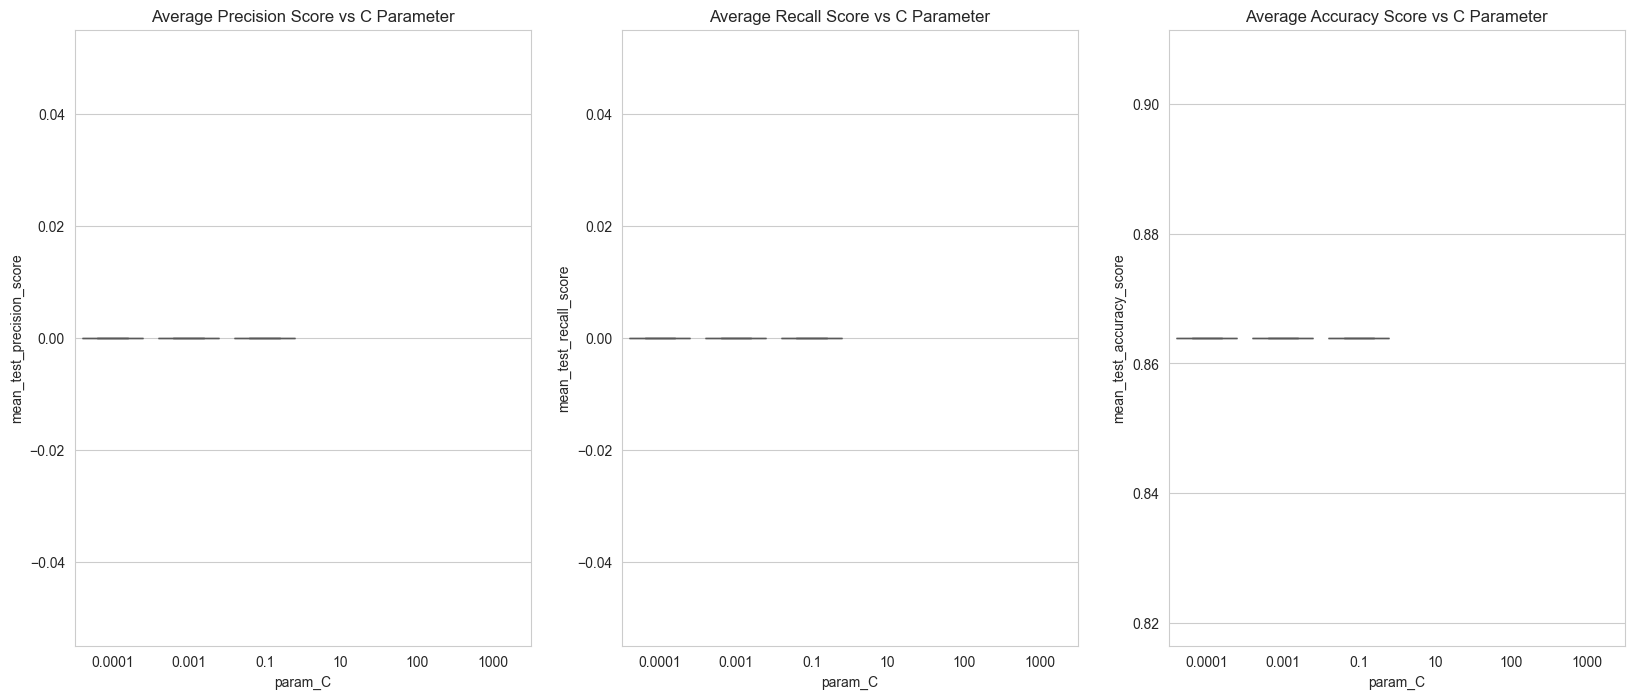

In [18]:
fig, axes = plt.subplots(figsize=(20, 8), nrows=1, ncols=3)
sns.boxplot(data=res_df, x="param_C", y="mean_test_precision_score", ax=axes[0])
axes[0].set_title('Average Precision Score vs C Parameter')
# axes[0].set(ylim=(-0.000001, 0.000001))

sns.boxplot(data=res_df, x="param_C", y="mean_test_recall_score", ax=axes[1])
axes[1].set_title('Average Recall Score vs C Parameter')

sns.boxplot(data=res_df, x="param_C", y="mean_test_accuracy_score", ax=axes[2])
axes[2].set_title('Average Accuracy Score vs C Parameter')

In [19]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np

In [20]:
def graph_Scores(scoreMetric):
    x_ticks = [0.0001, 0.001, 0.1, 1, 10, 100, 1000]
    data_1 = res_df[res_df['param_C'] == 0.0001][scoreMetric]
    data_2 = res_df[res_df['param_C'] == 0.001][scoreMetric]
    data_3 = res_df[res_df['param_C'] == 0.1][scoreMetric]
    data_4 = res_df[res_df['param_C'] == 10][scoreMetric]
    data_5 = res_df[res_df['param_C'] == 100][scoreMetric]
    data_6 = res_df[res_df['param_C'] == 1000][scoreMetric]
    data = [data_1, data_2, data_3, data_4, data_5, data_6]
    
    fig = plt.figure(figsize =(3, 2))
    ax = fig.add_axes([0, 0, 1, 1])
    ax.set_xlabel(x_ticks)
    
    ax.boxplot(data)
    plt.title('C vs ' + scoreMetric)
    plt.show()

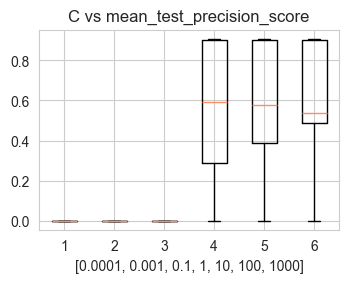

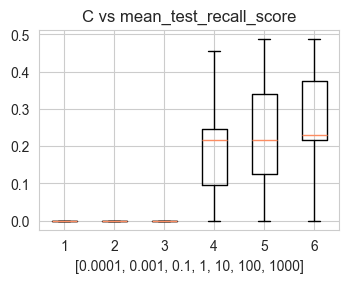

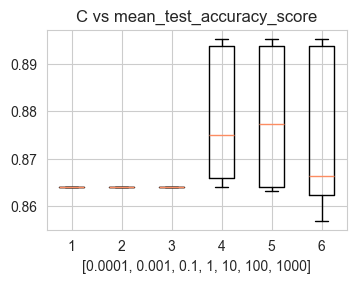

In [21]:
graph_Scores('mean_test_precision_score')
graph_Scores('mean_test_recall_score')
graph_Scores('mean_test_accuracy_score')

Text(0.5, 1.0, 'Average Accuracy Score vs Gamma Parameter')

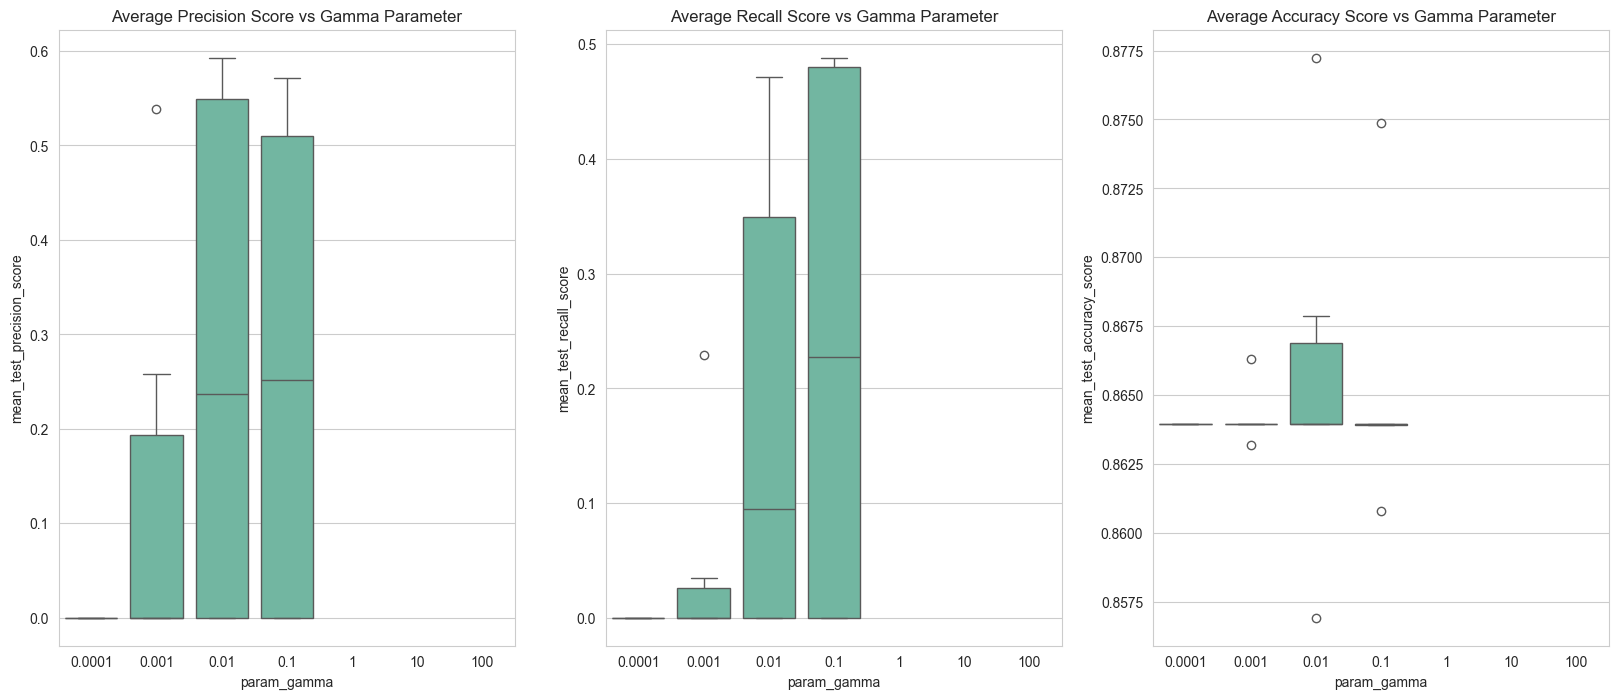

In [22]:
fig, axes = plt.subplots(figsize=(20, 8), nrows=1, ncols=3)

sns.boxplot(data=res_df, x="param_gamma", y="mean_test_precision_score", ax=axes[0])
axes[0].set_title('Average Precision Score vs Gamma Parameter')

sns.boxplot(data=res_df, x="param_gamma", y="mean_test_recall_score", ax=axes[1])
axes[1].set_title('Average Recall Score vs Gamma Parameter')

sns.boxplot(data=res_df, x="param_gamma", y="mean_test_accuracy_score", ax=axes[2])
axes[2].set_title('Average Accuracy Score vs Gamma Parameter')

**Question 4** What can you say about the two sets of graphs above? IF the graphs are not interpetable, run your own descriptive statistics to help discuss the results.

### C results
* C seems to start affecting all scores when `C >= 10`
* For precision. Increasing C, primarily decreases the dispersion of the scores. Distribution remains `symetric` when considering whiskers.
* For recall. Increasing C, primarily increases the scores of the interquartile range rising. Distribution remains `symetric` when considering whiskers
* For accuracy. Increasing C, can increase the minimum value/whiskers. Distribution was observed to be more `positively skewed`.

C is essentially the penalty multiplier. It has an indirect relationship to the decision boundary's size since increasing penalties will discourage larger margins.

Increasing C can increase the chances of correctly classifying classes. For actually achieving True Positives, the results show mostly even median chances from recall and precision having symetric distributions. In addition, distribution does get more narrow for precision scores and IQR rose for recall scores.

### Gamma results
* Gamma seems to have effect only when `Gamma <= 0.1`
* For precision, a `direct relationship` was observed with increased positive range/whiskers. It skews towards `symmetry`.
* For recall, gamma signifcantly increases both maximum values and dispersion. It skews towards `symmetry`.
* Accuracy seems to only increase at `Gamma = 0.01`.

Gamma is the inverse of a vector's influence size and is stated to be the most sensitive parameter.

It can be seen that increasing gamma can increase the scores, provided it's within a threshold. Selecting True Positives were generally more probable in higher Gamma valies. Accuracy may be the harder metric to base by since it only increased on a specific gamma value. 

## Using RandomSearch

For large datasets Gridsearch might be too intensive, an alternative would be to use Randomized Search. This approach will randomly choose different settings to experiment with. This functionality also gives you the ability to choose the number of iterations to run so that your models wont run too long.

In [23]:
from sklearn.model_selection import RandomizedSearchCV

In [24]:
param_grid = {
    'C': [0.1, 0.001, 0.001, 10, 100, 1000],
    'gamma': [100, 10, 1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf']
}
clf_grid = RandomizedSearchCV(SVC(), param_grid, verbose=3, n_iter=50)
clf_grid.fit(X_train, y_train)

C:\Users\cmath\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 42 is smaller than n_iter=50. Running 42 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 42 candidates, totalling 210 fits
[CV 1/5] END ......C=0.1, gamma=100, kernel=rbf;, score=0.863 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=100, kernel=rbf;, score=0.863 total time=   0.0s
[CV 3/5] END ......C=0.1, gamma=100, kernel=rbf;, score=0.863 total time=   0.0s
[CV 4/5] END ......C=0.1, gamma=100, kernel=rbf;, score=0.863 total time=   0.0s
[CV 5/5] END ......C=0.1, gamma=100, kernel=rbf;, score=0.867 total time=   0.0s
[CV 1/5] END .......C=0.1, gamma=10, kernel=rbf;, score=0.863 total time=   0.0s
[CV 2/5] END .......C=0.1, gamma=10, kernel=rbf;, score=0.863 total time=   0.0s
[CV 3/5] END .......C=0.1, gamma=10, kernel=rbf;, score=0.863 total time=   0.0s
[CV 4/5] END .......C=0.1, gamma=10, kernel=rbf;, score=0.863 total time=   0.0s
[CV 5/5] END .......C=0.1, gamma=10, kernel=rbf;, score=0.867 total time=   0.0s
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.863 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf

RandomizedSearchCV(estimator=SVC(), n_iter=50,
                   param_distributions={'C': [0.1, 0.001, 0.001, 10, 100, 1000],
                                        'gamma': [100, 10, 1, 0.1, 0.01, 0.001,
                                                  0.0001],
                                        'kernel': ['rbf']},
                   verbose=3)

Get best estimator and calculate score

In [25]:
clf_grid.best_estimator_

SVC(C=10, gamma=1)

In [26]:
clf_grid.cv_results_

{'mean_fit_time': array([0.07381606, 0.0740129 , 0.06363721, 0.02715888, 0.01615095,
        0.01495457, 0.01317763, 0.03131423, 0.02612472, 0.018151  ,
        0.01276541, 0.0125658 , 0.0139585 , 0.01456113, 0.03333211,
        0.03051343, 0.0175539 , 0.01356845, 0.01276278, 0.01396012,
        0.01276536, 0.08278341, 0.08516369, 0.06862316, 0.04288206,
        0.02155442, 0.03050761, 0.02712641, 0.08168049, 0.07441144,
        0.06823206, 0.03909583, 0.03769388, 0.02952824, 0.04549079,
        0.07779598, 0.07978349, 0.06702218, 0.0381124 , 0.1107038 ,
        0.08078833, 0.06223006]),
 'std_fit_time': array([0.00179648, 0.0025555 , 0.00160281, 0.00044828, 0.00038779,
        0.00063114, 0.00075565, 0.00048582, 0.00096717, 0.00039854,
        0.00074654, 0.00079725, 0.00168729, 0.00271795, 0.00081382,
        0.00627947, 0.00048714, 0.00080648, 0.0007458 , 0.00064101,
        0.00075764, 0.00814746, 0.00877586, 0.00276832, 0.00166387,
        0.00121644, 0.00871311, 0.0018281 , 0.009

In [27]:
y_pred = clf_grid.best_estimator_.predict(X_test)
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

0.8666666666666667
0.3023255813953488
0.4482758620689655


## Exercise Use Gridsearch on Logistic Regression

In [28]:
from sklearn.linear_model import LogisticRegression

## create a parameter grid with different settings for C (0.1, 0.001, 0.0001, 1, 10, 100) and penalty (l1, l2)

In [29]:
param_grid = {
    'C': [0.1, 0.001, 0.0001, 1, 10, 100],
    'penalty': ['l1', 'l2'],
}

## run gridsearch using the logistic regression class for scikit learn

In [30]:
clf_grid = GridSearchCV(LogisticRegression(solver="liblinear"), param_grid, refit = True, verbose = 3)
clf_grid.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END .................C=0.1, penalty=l1;, score=0.859 total time=   0.0s
[CV 2/5] END .................C=0.1, penalty=l1;, score=0.859 total time=   0.0s
[CV 3/5] END .................C=0.1, penalty=l1;, score=0.867 total time=   0.0s
[CV 4/5] END .................C=0.1, penalty=l1;, score=0.863 total time=   0.0s
[CV 5/5] END .................C=0.1, penalty=l1;, score=0.886 total time=   0.0s
[CV 1/5] END .................C=0.1, penalty=l2;, score=0.863 total time=   0.0s
[CV 2/5] END .................C=0.1, penalty=l2;, score=0.859 total time=   0.0s
[CV 3/5] END .................C=0.1, penalty=l2;, score=0.871 total time=   0.0s
[CV 4/5] END .................C=0.1, penalty=l2;, score=0.867 total time=   0.0s
[CV 5/5] END .................C=0.1, penalty=l2;, score=0.871 total time=   0.0s
[CV 1/5] END ...............C=0.001, penalty=l1;, score=0.863 total time=   0.0s
[CV 2/5] END ...............C=0.001, penalty=l1;

GridSearchCV(estimator=LogisticRegression(solver='liblinear'),
             param_grid={'C': [0.1, 0.001, 0.0001, 1, 10, 100],
                         'penalty': ['l1', 'l2']},
             verbose=3)

## get best performing model and calculate score

In [31]:
clf_grid.best_estimator_.score(X_test, y_test)

0.89375

## show the feature importance plot

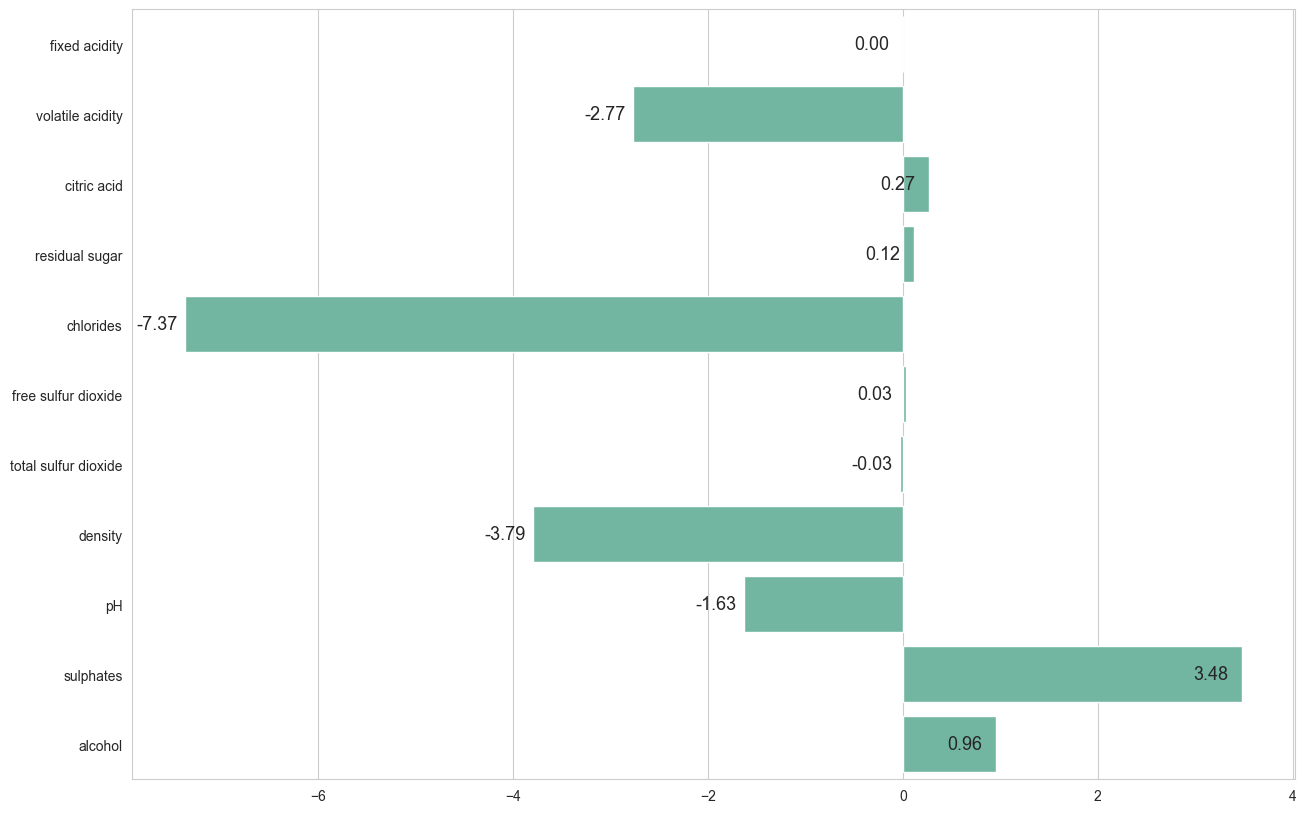

In [32]:
cols = X_train.columns.to_list()
fig, ax = plt.subplots(figsize=(15,10))
sns.barplot(x=clf_grid.best_estimator_.coef_[0], y=cols)

for p in ax.patches:
    width = p.get_width()    # get bar length
    ax.text(width - .5,       # set the text at 1 unit right of the bar
            p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
            '{:1.2f}'.format(width), # set variable to display, 2 decimals
            ha = 'left',   # horizontal alignment
            va = 'center',
            fontsize=13)  # vertical alignmen